In [1]:
import findspark
findspark.init()
from pyspark import SparkContext

#sc.stop()
sc = SparkContext(master="local[6]",pyFiles=['lib/spark_PCA.py'])

from pyspark.sql import *
sqlContext = SQLContext(sc)

%pylab inline
import sys
sys.path.append('./lib')

import numpy as np
from spark_PCA import computeCov


Populating the interactive namespace from numpy and matplotlib


In [3]:
df=sqlContext.read.csv('../SP500.csv',header='true',inferSchema='true')
df.count()

13422

In [21]:
columns=df.columns
col=[c for c in columns if '_D' in c]
tickers=[a[:-2] for a in col]
tickers[:10],len(tickers)

(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA', 'WM', 'SPG'], 481)

In [ ]:
# Need to be able to select different subsets of stocks for different students
#subset=set(tickers)-set(['AGN', 'EOG', 'WLP', 'CPB', 'YUM', 'JWN', 'TAP', 'BWA'])
#df=df.select(list(subset))

In [5]:
def make_array(row):
    array=np.array([row[c] for c in col],dtype=np.float64)
    return np.nan_to_num(array)
Rows=df.select(col).rdd.map(make_array)

Rows.first()[:20]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.00830103,  0.        ,  0.        ,  0.        ,  0.        ])

In [6]:
OUT=computeCov(Rows)
OUT.keys()

shape of E= (481,) shape of NE= (481,)


['E', 'Cov', 'NO', 'NE', 'O', 'Var', 'Mean']

[ 0.21541202  0.25336645  0.27722061  0.29994765  0.31293977]


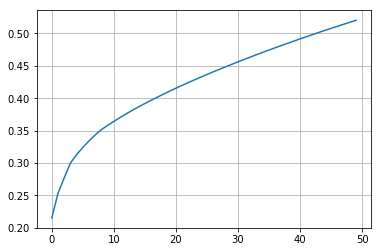

In [7]:
from numpy import linalg as LA
eigval,eigvec=LA.eigh(OUT['Cov'])
eigval=eigval[-1::-1] # reverse order
eigvec=eigvec[:,-1::-1]
cum=cumsum(eigval)
cum=cum/cum[-1]
print cum[:5]
plot(cum[:50])
grid()

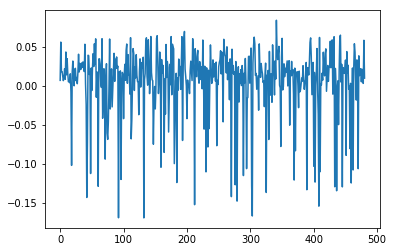

In [9]:
eigen_vecs=eigvec.transpose
plot(eigvec[:,1])

In [12]:
import pickle
with open('EigvecsAll.pkl','wb') as pkl:
    pickle.dump({'eigval':eigval,
                 'eigvec':eigvec}
               ,pkl)
    !ls -lrt *.pkl

-rw-r--r--  1 yoavfreund  staff    35737 Jun  6 12:53 Tickers.pkl
-rw-r--r--  1 yoavfreund  staff  5300224 Jun  6 19:50 EigvecsAll.pkl


In [10]:
import pickle
D=pickle.load(open('Tickers.pkl','rb'))
TickerInfo=D['TickerInfo']
tickers=D['Tickers']
TickerInfo.head()

,Ticker,Name,Sector,SECTOR_ID
0,MMM,3M|3M Company,Industrials,INDS
1,ABT,Abbott Laboratories,Health Care,HC
2,ABBV,AbbVie Inc.,Health Care,HC
3,ACN,Accenture plc,Information Technology,IT
4,ATVI,Activision Blizzard,Information Technology,IT


In [11]:
TickerInfo[TickerInfo['SECTOR_ID']=='EN']

,Ticker,Name,Sector,SECTOR_ID
41,APC,Anadarko Petroleum|Anadarko Petroleum Corp,Energy,EN
45,APA,Apache Corporation,Energy,EN
60,BHI,Baker Hughes Inc,Energy,EN
83,COG,Cabot Oil & Gas,Energy,EN
101,CHK,Chesapeake Energy,Energy,EN
102,CVX,Chevron Corp.,Energy,EN
107,XEC,Cimarex Energy,Energy,EN
124,CXO,Concho Resources,Energy,EN
125,COP,ConocoPhillips,Energy,EN
145,DVN,Devon Energy,Energy,EN


In [12]:
NN=TickerInfo[['Ticker','SECTOR_ID']]
Ticker2Sector={ a[1]:a[2] for a in NN.to_records()}
Ticker2Sector.items()[:3]

[('AGN', 'HC'), ('EOG', 'EN'), ('CPB', 'CS')]

In [13]:
sectors=[]
missing=[]
good_tickers=[]
for a in tickers:
    if a in Ticker2Sector:
        good_tickers.append(a)
        b=Ticker2Sector[a] 
    else:
        b=a
        missing.append(a)
    sectors.append(b)

print 'tickers=',len(tickers),'good tickers=',len(good_tickers),'missing=',len(missing)



tickers= 481 good tickers= 392 missing= 89


In [14]:
len(sectors),len(tickers)

(481, 481)

In [26]:
# Generate the scatter plot of the stocks on a pair of eigen-vectors defined by i0,i1
def Scatter_Stocks(i0=0,i1=1):
    fig, ax = plt.subplots(figsize=(20,20))  # In order that the stock ticker names are readable we make the plot very large
    plt.xlim([np.amin(eigvec[:,i0]),np.amax(eigvec[:,i0])])
    plt.ylim([np.amin(eigvec[:,i1]),np.amax(eigvec[:,i1])])
    plt.title('SP500 stocks scatter on '+str(i0)+', '+str(i1),fontsize=20)
    plt.xlabel('Coeff %d'%i0)
    plt.ylabel('Coeff %d'%i1)
    for i in range(len(tickers)):
        #ax.annotate(tickers[i], (eigvec[i0,i],eigvec[i1,i]),fontsize=10)
        ax.annotate(sectors[i], (eigvec[i,i0],eigvec[i,i1]),fontsize=10);
    # This very large plot is hard to view and manipulate inside the notebook. We therefor export it into a pdf file
    fig.savefig('scatter.'+str(i0)+'.'+str(i1)+'.pdf', format='PDF');
    # After exporting, we clear the figure so that the plot does not appear in the notebook.
    fig.clear();

In [27]:
!rm *.pdf
for i0 in range(4):
    for i1 in range(i0):
        Scatter_Stocks(i0,i1)
!open *.pdf

In [28]:
!ls -l *.pdf

-rw-r--r--@ 1 yoavfreund  staff  25723 Jun  6 13:18 scatter.1.0.pdf
-rw-r--r--@ 1 yoavfreund  staff  25705 Jun  6 13:18 scatter.2.0.pdf
-rw-r--r--@ 1 yoavfreund  staff  23856 Jun  6 13:18 scatter.2.1.pdf
-rw-r--r--@ 1 yoavfreund  staff  25751 Jun  6 13:18 scatter.3.0.pdf
-rw-r--r--@ 1 yoavfreund  staff  23976 Jun  6 13:18 scatter.3.1.pdf
-rw-r--r--@ 1 yoavfreund  staff  24327 Jun  6 13:18 scatter.3.2.pdf


### Performing K-NN on sectors.

In [32]:
eigvec.shape

(481, 481)

In [33]:
Tick_rep={}
for i in range(len(tickers)):
    Tick_rep[tickers[i]]=eigvec[i,:]

In [34]:
len(sectors)

481

In [130]:
d=20
k=5
T='HAL'
def find_closest(T,d=10,k=10):
    v=np.array([Tick_rep[T][:d]])
    g=eigvec[:,:d]
    v.shape, g.shape
    D=g-v

    A=sum(D**2,axis=1)
    paired=zip(tickers,sectors,A)
    return sorted(paired,key=lambda x:x[2])[:k+1]

In [131]:
from collections import Counter

In [136]:
def correct_vote(ticker):
    closest=find_closest(ticker)
    self_sector=closest[0][1]
    Votes=Counter([a[1] for a in closest[1:]])
    sVotes=sorted(Votes.items(),key=lambda x:x[1],reverse=True)
    return self_sector,sVotes[0][0],sVotes

In [137]:
correct_vote('AMZN')

('CD', 'IT', [('IT', 4), ('FIN', 2), ('CD', 2), ('CS', 1), ('RE', 1)])

In [139]:
correct=0
incorrect=0
for ticker in tickers:
    s,v,sVotes = correct_vote(ticker)
    if s==v:
        correct+=1
    else:
        print ticker,sVotes
        incorrect+=1
correct,incorrect

WLP [('CS', 3), ('INDS', 2), ('HC', 2), ('RE', 1), ('HSP', 1), ('DTV', 1)]
YUM [('IT', 2), ('CD', 2), ('CS', 2), ('INDS', 1), ('DF', 1), ('RE', 1), ('HC', 1)]
BWA [('INDS', 3), ('MAT', 2), ('CD', 2), ('HOT', 1), ('X', 1), ('EMC', 1)]
WM [('CS', 4), ('INDS', 2), ('DF', 1), ('IT', 1), ('CD', 1), ('RE', 1)]
FIS [('INDS', 2), ('CD', 2), ('TWC', 1), ('WIN', 1), ('IT', 1), ('RE', 1), ('CS', 1), ('DTV', 1)]
GT [('INDS', 4), ('MAT', 3), ('AA', 1), ('RE', 1), ('UTIL', 1)]
MJN [('CD', 2), ('RE', 2), ('CFN', 1), ('ADT', 1), ('EN', 1), ('INDS', 1), ('IT', 1), ('HC', 1)]
AMZN [('IT', 4), ('FIN', 2), ('CD', 2), ('CS', 1), ('RE', 1)]
FII [('FIN', 5), ('RE', 3), ('IT', 2)]
MAT [('MAT', 2), ('INDS', 2), ('CD', 2), ('EN', 1), ('BEAM', 1), ('BMS', 1), ('THC', 1)]
SNA [('INDS', 3), ('MAT', 2), ('CD', 2), ('EN', 1), ('BMS', 1), ('THC', 1)]
SNI [('IT', 2), ('CD', 2), ('CS', 2), ('TWC', 1), ('WIN', 1), ('HSP', 1), ('DTV', 1)]
XYL [('IT', 2), ('CD', 2), ('RE', 2), ('ADT', 1), ('EN', 1), ('CS', 1), ('HC', 1)]


(241, 240)